# Monte Carlo Simulation

## Phase transitions class, Summer 2018

Allen Scheie, taught by Oleg Tchernyshyov

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import time as time

from numba import njit, jitclass
from numba import int32, float32    # import the types

## Theory

Say we have a system with microstates $\{ \alpha \}$, each with energy $E_{\alpha}$.

We want to realize a macrostate at some temperature $T$ or inverse temperature $\beta = 1/k_B T$.

$$P_{\alpha} = \frac{1}{Z} e^{-\beta E_{\alpha}}$$

We want to put the code into the computer so that the computer emulates this state.

#### How do we do this?

When we input a system into a computer, we start in some state. $P_{\alpha,0}=1$, $P_{\beta,0}=0$ for $\beta \neq \alpha$.

We start in a state, flip a coin, and then move to the other state. With three states and a fair (three-sided) coin, we'll spend 1/3 of the time in every state.
But let's say our coin is not fair.
We can transition from state $\alpha$ to state $\beta$ with probability $w_{\beta \alpha}$, and to state $\gamma$ $w_{\gamma \alpha}$.

$\sum_{\beta} w_{\beta \alpha} =1$,  definitely going somewhere.

At time $t$, the probability distribution is $P_{\alpha,t}$. At time $t+1$, $P_{\beta,t+1}=\sum_{\alpha} w_{\beta \alpha} P_{\alpha, t}$. 

$w_{\beta \alpha}$ have to be specified.

##### The eventual goal: reach a thermal state (after a large enough number of iterations) such that 
$$P_{\mu, \infty} =  \frac{1}{Z} e^{-\beta E_{\mu}}$$

$\lim_{t -> \infty} P_{\mu, t} = P_{\mu, \infty}$

$P_{\mu, \infty} -->  P_{\mu, \infty+1} = P_{\mu, \infty}$

$P_{\gamma, \infty+1} = \sum_{\alpha} w_{\gamma \alpha} P_{\alpha, \infty}$

$0=P_{\gamma, \infty+1} - P_{\gamma, \infty} = \sum_{\alpha}( w_{\gamma \alpha} P_{\alpha, \infty} - w_{\alpha \gamma } P_{\gamma, \infty})$    (prob into gamma - prob. out of gamma)

Things will be simplified for our simulations if we establish detailed balance in thermal equilibrium:
$w_{\gamma \alpha} P_{\alpha, \infty} = w_{\alpha \gamma} P_{\gamma, \infty}$

or $w_{\gamma \alpha} \frac{1}{Z} e^{-\beta E_{\alpha}} = w_{\alpha \gamma} \frac{1}{Z} e^{-\beta E_{\gamma}}$

and $w_{\gamma \alpha} = w_{\alpha \gamma} \frac{1}{Z} e^{-\beta (E_{\gamma} - E_{\alpha})}$

### Essence of the Metropolis algorithm:

You go down in energy with probability 1. You go up in energy with probability $e^{-\beta (E_{\gamma} - E_{\alpha})}$

In a spin system, you attempt to flip a spin, check the energy difference $\Delta E$. If $\Delta E \leq 0$, accept the move. If $\Delta E \geq 0$, accept with $w = e^{-\beta \Delta E}$. (Generate random number between 0 and 1, compare to $ e^{-\beta \Delta E}$.

### CONVERGENCE:

Define distance $\delta_t = \sum_{\alpha} |P_{\alpha,t} - P_{\alpha,\infty}|$

##### Want $\delta_t --> 0$ as $t --> \infty$

 $\delta_{t+1} = \sum_{\alpha} |P_{\alpha,t+1} - P_{\alpha,\infty}|$
 
 $=  \sum_{\alpha} | \sum_{\gamma} w_{\alpha \gamma} P_{\gamma,t} - P_{\alpha,\infty}|$
 
 $=  \sum_{\alpha} | \sum_{\gamma} w_{\alpha \gamma} P_{\gamma,t} - w_{\gamma \alpha} P_{\alpha,\infty}|$
 
 by detailed balance,  $=  \sum_{\alpha} | \sum_{\gamma} w_{\alpha \gamma} P_{\gamma,t} - w_{\alpha \gamma} P_{\gamma,\infty}|$
 
 and so we find $\delta_{t+1} = \sum_{\alpha} |\sum_{\gamma} w_{\alpha \gamma} (P_{\gamma,t}- P_{\gamma,\infty})|$
 
 .
 
 Now, we invoke a trick: $|\sum_{\gamma} x_{\gamma}| \leq \sum_{\gamma} |x_{\gamma}|$.
 
 Therefore, $\delta_{t+1} \leq \sum_{\alpha} \sum_{\gamma} |w_{\alpha \gamma} (P_{\gamma,t}- P_{\gamma,\infty})|$
 
 We re-shuffle the sum signs, and get 
 $$\delta_{t+1} \leq \sum_{\gamma} \underbrace{\sum_{\alpha} w_{\alpha \gamma}}_{1} |(P_{\gamma,t}- P_{\gamma,\infty})|$$
 so
$$\delta_{t+1} \leq \sum_{\gamma} |(P_{\gamma,t}- P_{\gamma,\infty})|$$

and thus, $\delta_{t+1} < \delta_t$ if $\delta_t \neq 0$.


### Evaluating energy:

$$\Delta E = -S_{x,y} h_{x,y}$$, where $h_{x,y} = J \sum_{n,n'} S_{x',y'}$

If I flip a central spin on a grid, $\Delta E = 2 S_{x,y} h_{x,y} = 0$, $\pm 4J$, $\pm 8J$.

The point is not to get the largest system size possible, but the point is to compare system sizes and then extract critical exponents from them.

## Practical points:
run a number of sweeps through the lattice, flipping spins. Compute observables.

Be careful! Near the critical point, things slow down so it takes many many more moves to change microstates. You can avoid this slow-down almost completely with cluster algorithms.

- With the Ising model we know where the phase transition will be. But with a different model, we don't necessarily know. In order to determine where the transition is, there's a neat trick:
    - $U_4 = 1- \frac{\langle m^4 \rangle}{3 \langle m^2 \rangle^2}$
    - low $T$: $\langle m^2 \rangle = N^2$, $\langle m^4 \rangle = N^4$
        - $U_4 = 1- \frac{1}{3} = 2/3$
    - high $T$: $\langle m^4 \rangle = 3\langle m^2 \rangle \langle m^2 \rangle$ (count number of ways to combine $m$)

In [2]:
spec = [
    ('size', int32),               # a simple scalar field
    ('spins', float32[:,:]),          # an array field
    ('J', float32),
    ('kb', float32),
    ('T', float32),
    ('E2avg', float32),
    ('Eavg', float32),
    ('Mavg', float32),
    ('C', float32),
    ('U4', float32),
    ('MvT', float32[:]),
    ('CvT', float32[:]),
    ('U4vT', float32[:]),
]

@jitclass(spec)
class isingGrid(object):
    def __init__(self,size,J):
        self.spins = np.zeros((size,size), dtype=np.float32) +1
        self.size=size
        self.J = J
        self.kb = 1
        self.T = 1
        
    def energy(self):
        e = 0
        for i in range(self.size):
            for j in range(self.size):
                e += -self.J*(self.spins[i,j] * self.spins[i-1,j] +\
                        self.spins[i,j] * self.spins[i,j-1])
        return e
        
    def magnetization(self):
        return np.sum(self.spins)
    
    def equilibrate(self, T, samples):
        self.T = T
        w = np.zeros(3)
        w[0] = 1
        w[1] = np.exp(-2*self.J/(self.kb * self.T))
        w[2] = np.exp(-4*self.J/(self.kb * self.T))
        
        # Sweep to equilibrate:
        for i in range(10*self.size**2):
            self.sweep(w)
            
        self.Eavg = 0
        self.E2avg = 0
        self.Mavg = 0
        m2 = 0
        m4 = 0
        # Make measurements
        for i in range(samples):
            for j in range(10):
                self.sweep(w)
            self.sweep(w)
            
            EE = self.energy()
            self.Eavg += EE
            self.E2avg += EE**2
            m = np.abs(self.magnetization())
            self.Mavg += m
            m2 += m**2
            m4 += m**4
            
        self.Eavg /= samples
        self.E2avg /= samples
        self.Mavg /= samples
        m2 /= samples
        m4 /= samples
        
        self.C = (self.E2avg - self.Eavg**2)/(self.kb*self.T**2) /self.size**2
        self.U4 = 1 - m4/(3*m2**2)
        
    def sweep(self, w):
        for i in range(self.size**2):
            # Pick a random site
            ii, jj = np.random.randint(0,self.size, 2)
            #ii, jj = iii%self.size, jjj%self.size
            # Compute energy increment if n is flipped
            hxy = self.spins[(ii-1)%self.size,jj%self.size] + self.spins[(ii+1)%self.size,jj%self.size] +\
                        self.spins[ii%self.size, (jj-1)%self.size] + self.spins[ii%self.size,(jj+1)%self.size] 
            dE = hxy*self.spins[ii,jj]*self.J
            
            if dE <= 0: 
                self.spins[ii,jj] = -self.spins[ii,jj]
            else:
                randnum = np.random.uniform(0,1)
                if dE == 0:
                    prob = w[0]
                if dE == 2*self.J:
                    prob = w[1]
                elif dE == 4*self.J:
                    prob = w[2]
                if randnum < prob: 
                    self.spins[ii,jj] = -self.spins[ii,jj]
                    
                    
    def scanT(self, Tlist, samples):
        self.MvT = np.zeros(len(Tlist), dtype=np.float32)
        self.CvT = np.zeros(len(Tlist), dtype=np.float32)
        self.U4vT = np.zeros(len(Tlist), dtype=np.float32)
        for i, T in enumerate(Tlist):
            self.equilibrate(T, samples)
            self.MvT[i] = (self.Mavg / self.size**2)**2
            self.CvT[i] = self.C 
            self.U4vT[i] = self.U4

In [3]:
start = time.time()

I40 = isingGrid(40,1)
I20 = isingGrid(20,1)
I10 = isingGrid(10,1)
I5 = isingGrid(5,1)
# I40 = isingGrid(40,1)

temp = np.linspace(2.5,0.1,30)
I20.scanT(temp,1000)
print(time.time()-start)
I10.scanT(temp,1000)
print(time.time()-start)
I5.scanT(temp,1000)
print(time.time()-start)
# I40.scanT(temp,1000)

print(time.time()-start)

40.984458446502686
48.680065631866455
50.50902080535889
50.50912594795227


In [4]:
start = time.time()
I40 = isingGrid(40,1)
I40.scanT(temp,1000)
print(time.time()-start)

276.5156831741333


In [5]:
## 6.71 sec with njit
## 314.06 sec without

314.06/6.71

46.804769001490314

<IPython.core.display.Javascript object>


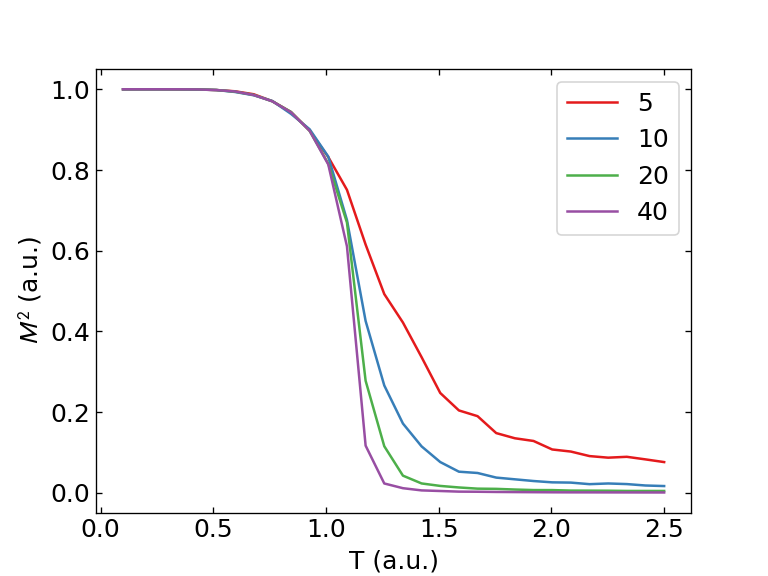

In [12]:
plt.figure()
plt.plot(temp, I5.MvT, label='5')
plt.plot(temp, I10.MvT, label='10')
plt.plot(temp, I20.MvT, label='20')
plt.plot(temp, I40.MvT, label='40')
plt.ylabel('$M^2$ (a.u.)')
plt.xlabel('T (a.u.)')
plt.legend()

<IPython.core.display.Javascript object>


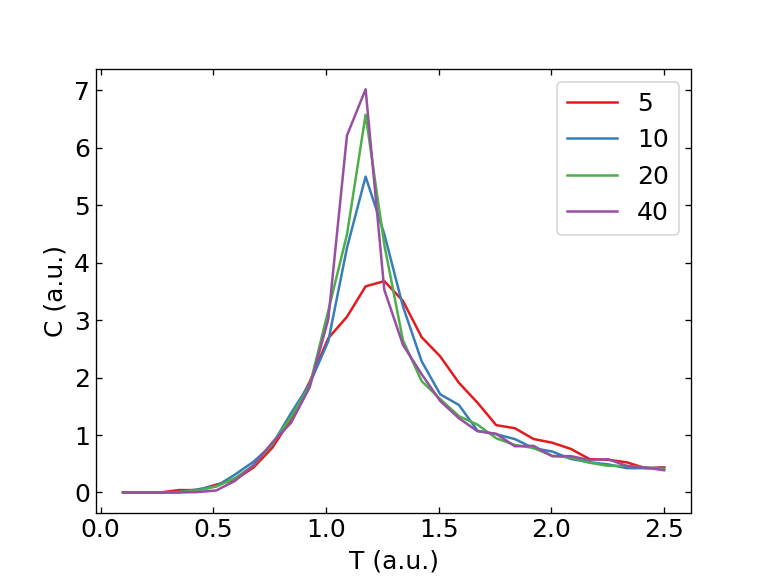

In [7]:
plt.figure()
plt.plot(temp, I5.CvT, label='5')
plt.plot(temp, I10.CvT, label='10')
plt.plot(temp, I20.CvT, label='20')
plt.plot(temp, I40.CvT, label='40')
plt.ylabel('C (a.u.)')
plt.xlabel('T (a.u.)')
plt.legend()

<IPython.core.display.Javascript object>


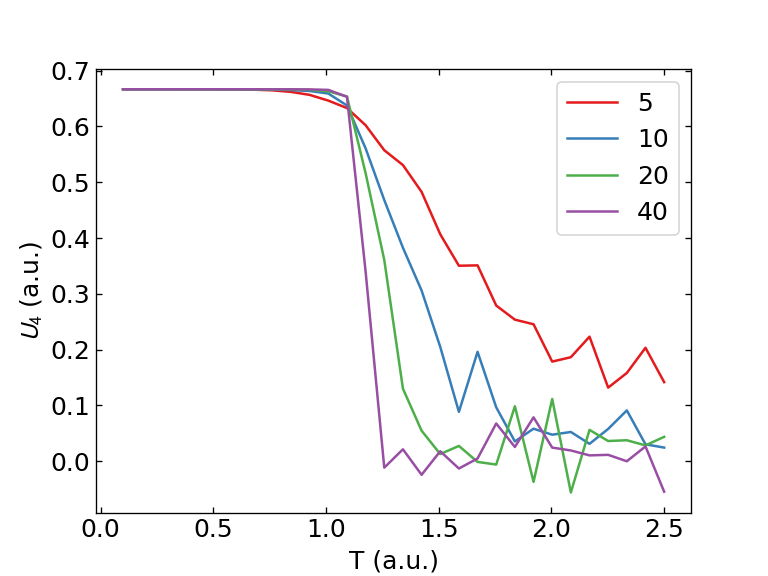

In [10]:
plt.figure()
plt.plot(temp, I5.U4vT, label='5')
plt.plot(temp, I10.U4vT, label='10')
plt.plot(temp, I20.U4vT, label='20')
plt.plot(temp, I40.U4vT, label='40')
plt.ylabel('$U_4$ (a.u.)')
plt.xlabel('T (a.u.)')
plt.legend()

# Discussion

One can re-scale heat capacity so that $tL^{y_t} = tL^{y_t}$, where $t = T-T_c$ and $y_t = 1$ for the Ising model. We'd need to adjust the height by $c = number \ln \frac{1}{t}$.

Susceptibility can be computed as well, and it scales like $\chi = |t|^{-\gamma}$ where $\gamma = 1.875$.

One can also scale magnetization.

using this, one can extract the critical exponents.